## Семинар 7: "Методы оптимизации"

ФИО:

In [19]:
import numpy as np
from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch import functional as F
from torch.autograd import Variable

%matplotlib notebook
import seaborn
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [39]:
class Optimizer():
    def __init__(self, variables):
        self.variables = variables
        
    def step(self, loss):
        pass
    
    
    
class GD(Optimizer):
    def __init__(self, variables, learning_rate):
        super().__init__(variables)
        self.lr = learning_rate
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v in self.variables:
                v -= self.lr * v.grad
                v.grad.data.zero_()
                
                
                
class Momentum(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g
                moment += self.lr * v.grad
                v -= moment
                v.grad.data.zero_()
                
                
                
class NAG(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g                
                v -= moment
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                v += moment
                moment += self.lr * v.grad
                v -= moment
                v.grad.data.zero_()
              
            
            
class Adagrad(Optimizer):
    def __init__(self, variables, learning_rate, eps=10**-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        
        self.g_sq = []
        for v in self.variables:
            self.g_sq.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, g_sq in zip(self.variables, self.g_sq):      
                g_sq += v.grad**2
                v -= self.lr / (g_sq + self.eps).sqrt() * v.grad
                v.grad.data.zero_()
             
            

class Adadelta(Optimizer):
    def __init__(self, variables, learning_rate, eps=10**-8, gamma=0.9, window=20):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        self.gamma = gamma
        self.window = window
        self.pos = 0
        self.g = []
        self.o = []
        
        for i in range(self.window):
            self.g.append(torch.ones_like(self.variables[0].data))
            self.o.append(torch.ones_like(self.variables[0].data))
            
        
    def step(self, J):
        loss = J()
        loss.backward()
        E_o = torch.ones_like(self.variables[0].data)
        E_g = torch.ones_like(self.variables[0].data)
        RMS_g = torch.ones_like(self.variables[0].data)
        RMS_o = torch.ones_like(self.variables[0].data)
        self.pos = (self.pos + 1) % self.window
        sum_grad = 0
        sum_delta = 0
        
        with torch.no_grad():
            for v in self.variables: 
                sum_grad += v.grad**2 / len(self.variables)
                E_g = self.gamma * E_g + (1 - self.gamma) * sum(self.g)
                RMS_g = (E_g + self.eps).sqrt()
                RMS_o = (E_o + self.eps).sqrt()
                
                delta = v.grad * RMS_o / RMS_g
                v.sub_(delta)
                
                sum_delta += delta**2 / len(self.variables)
                E_o = self.gamma * E_o + (1 - self.gamma) * sum(self.o)
                
                v.grad.data.zero_()
            
            self.pos = (self.pos + 1) % self.window
            self.g[self.pos] = sum_grad 
            self.o[self.pos] = sum_delta
            
        
                
                
                
class Adam(Optimizer):
    def __init__(self, variables, learning_rate, eps=10**-8, b1=0.9, b2=0.999):
        super().__init__(variables)
        self.lr = learning_rate
        self.step_number = 1
        self.eps = eps
        self.b1 = b1
        self.b2 = b2
        
    def step(self, J):
        loss = J()
        loss.backward()
        moment = torch.zeros_like(self.variables[0].data)
        speed = torch.zeros_like(self.variables[0].data)
        
        with torch.no_grad():
            for v in self.variables: 
                moment = self.b1 * moment + (1 - self.b1) * v.grad
                speed = self.b2 * speed + (1 - self.b2) * v.grad**2
                
                m = moment / (1 - self.b1**self.step_number)
                s = speed / (1 - self.b2**self.step_number)
                
                delta = self.lr * m / (s + self.eps).sqrt()
                v.sub_(delta)
                v.grad.data.zero_()
        
            self.step_number += 1
        
        

In [40]:
def apply_opt(x, y, optimizer, _J, n_iters=1000):    
    points = []
    X = Variable(torch.tensor(float(x)), requires_grad=True)
    Y = Variable(torch.tensor(float(y)), requires_grad=True) 
    opt = optimizer([X, Y])
    J = lambda X=X, Y=Y: _J(X, Y)
    
    for i in range(n_iters):
        points.append((X.item(), Y.item(), J().item()))
        opt.step(J)

    points = np.array(points)
    return points

In [41]:
def comparing(J, optims):
    
    R = 10
    X = np.linspace(-R, R, 100)
    Y = np.linspace(-R, R, 100)
    xx, yy = np.meshgrid(X, Y)
    xx = torch.from_numpy(xx)
    yy = torch.from_numpy(yy)
    Z = J(xx, yy)
    
    #plotting function
    fig = plt.figure(figsize=(9, 40))
    titles = ['GD', 'Momentum', 'NAG', 'Adagrad', 'Adadelta', 'Adam']
    ax = []
    for i in range(len(optims)):
        ax.append(fig.add_subplot(611 + i, projection='3d'))
        ax[i].set_title(titles[i])
        ax[i].set_xlim3d(-R, +R)
        ax[i].set_ylim3d(-R, +R)
        ax[i].set_zlim3d(-R, +R)
        ax[i].plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())

    #testing optimizers
    for i in range(len(optims)):
        points = apply_opt(8, 8, optims[i], J, 500)
        ax[i].plot(points[:, 0], points[:, 1], points[:, 2], c='red')
        
    plt.show()

In [42]:
optims = [lambda v: GD(v, 0.1), 
          lambda v: Momentum(v, 0.1),
          lambda v: NAG(v, 0.1), 
          lambda v: Adagrad(v, 0.1), 
          lambda v: Adadelta(v, 0.1),
          lambda v: Adam(v, 0.1)]

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [43]:
def J1(X, Y):
    return X**2 / 10 + Y**2 / 10

<IPython.core.display.Javascript object>


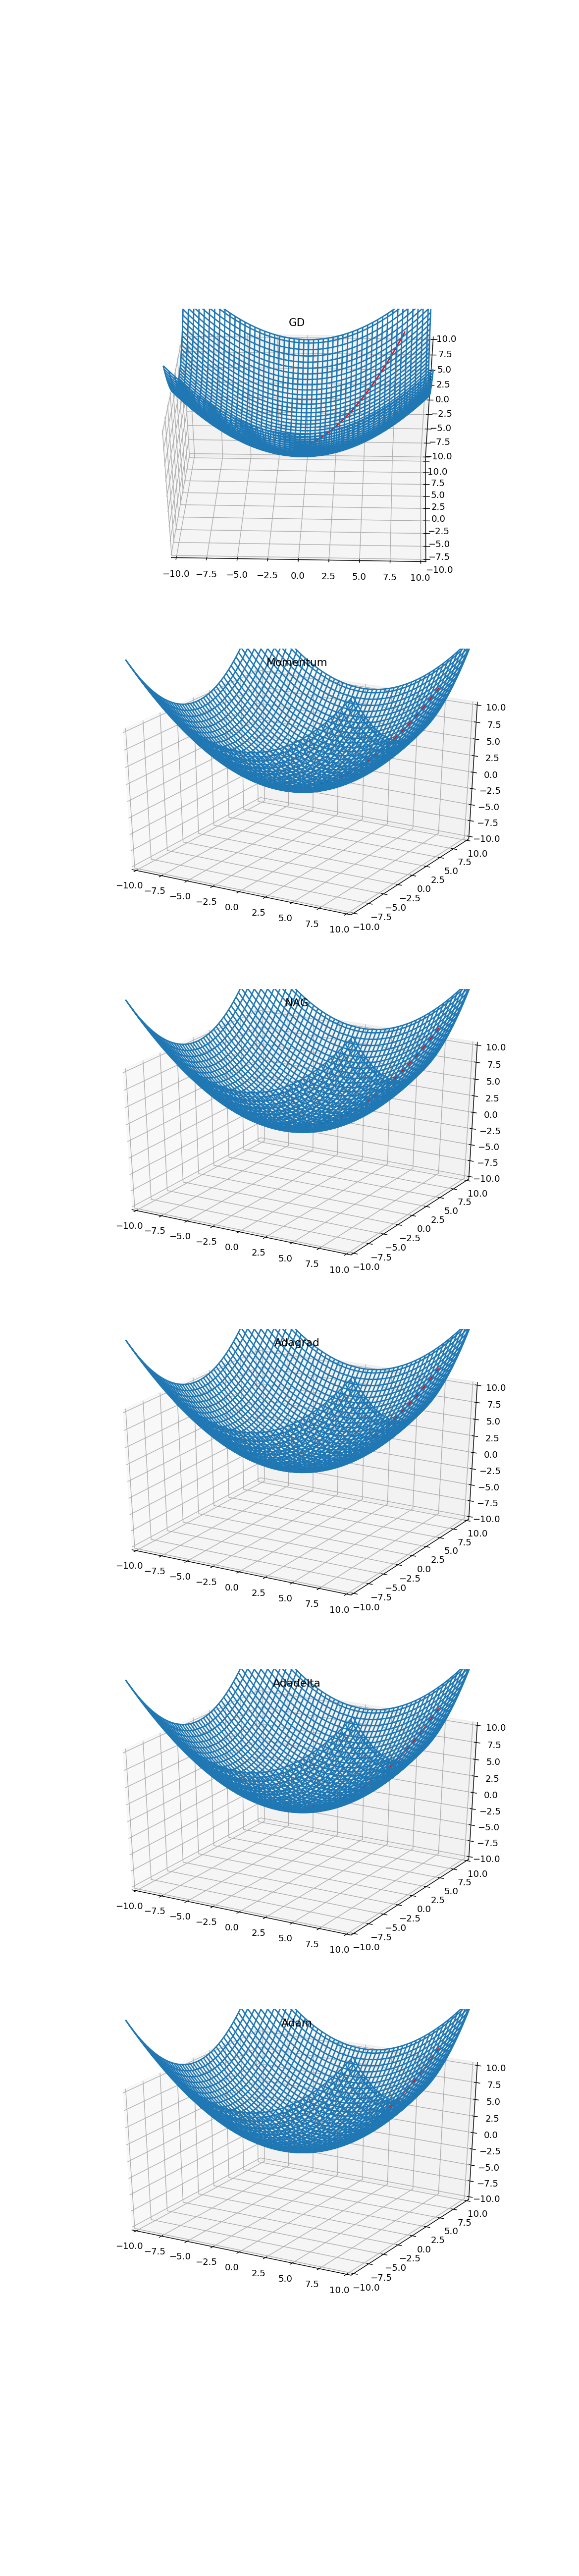

In [44]:
comparing(J1, optims)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [45]:
def J2(X, Y):
    return X**2 * X.sin() / 10 + Y**2 * Y.sin() / 10

<IPython.core.display.Javascript object>


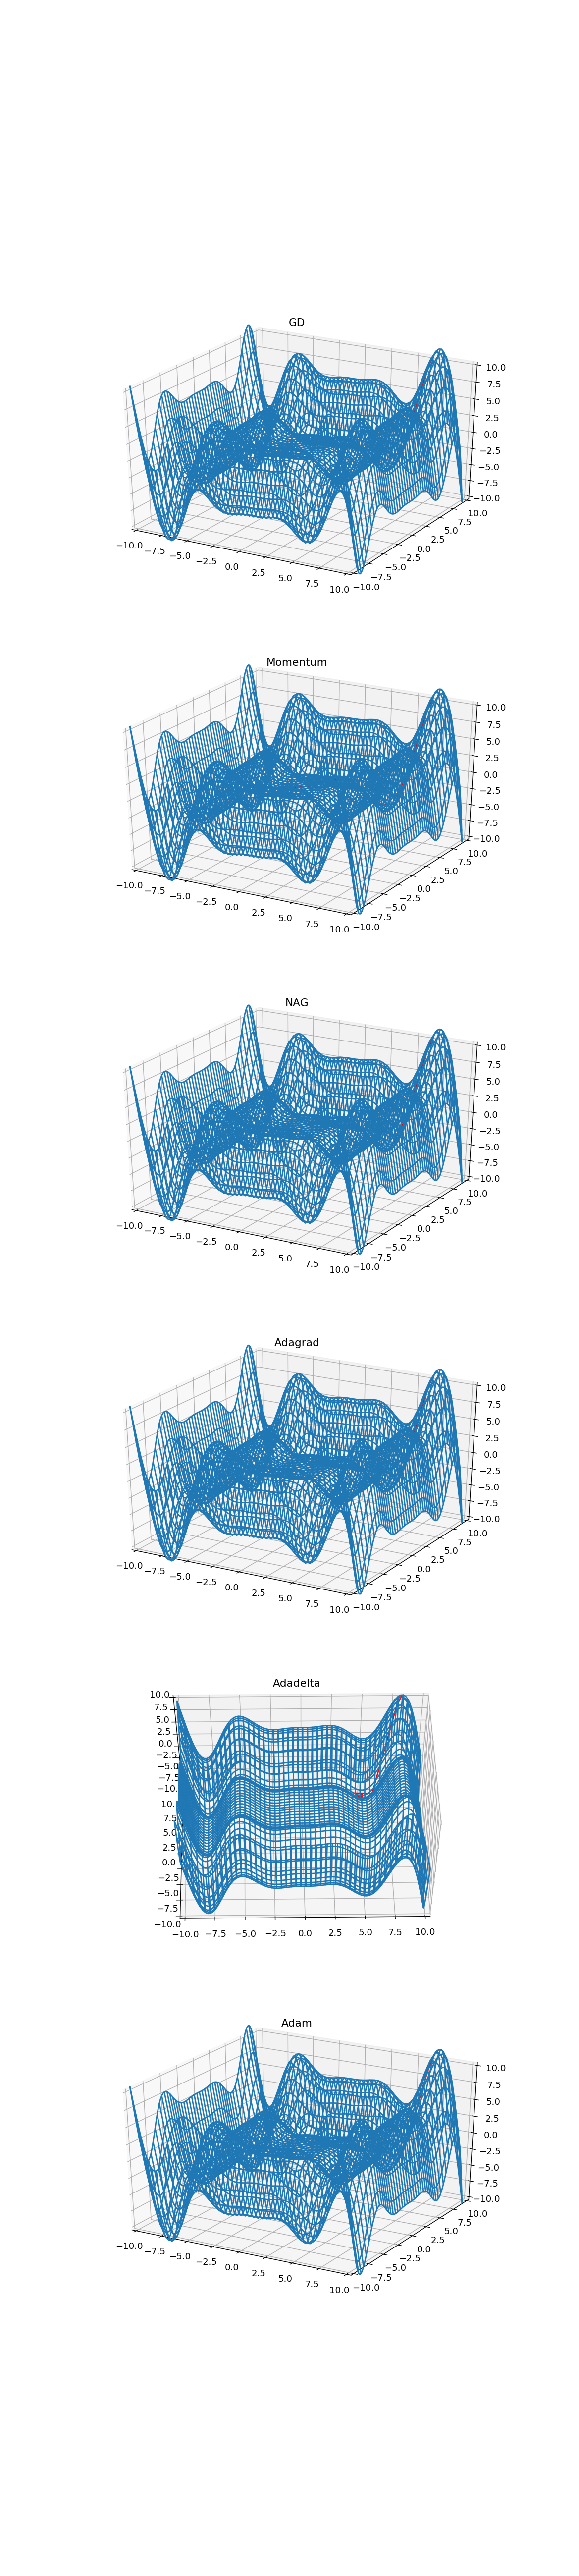

In [46]:
comparing(J2, optims)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [47]:
slow = 2.8
def J3(X, Y):
    return (X / slow)**2 * ((X / slow)**2).sin() / 5 + (Y / slow)**2 * ((Y / slow)**2).sin() / 5

<IPython.core.display.Javascript object>


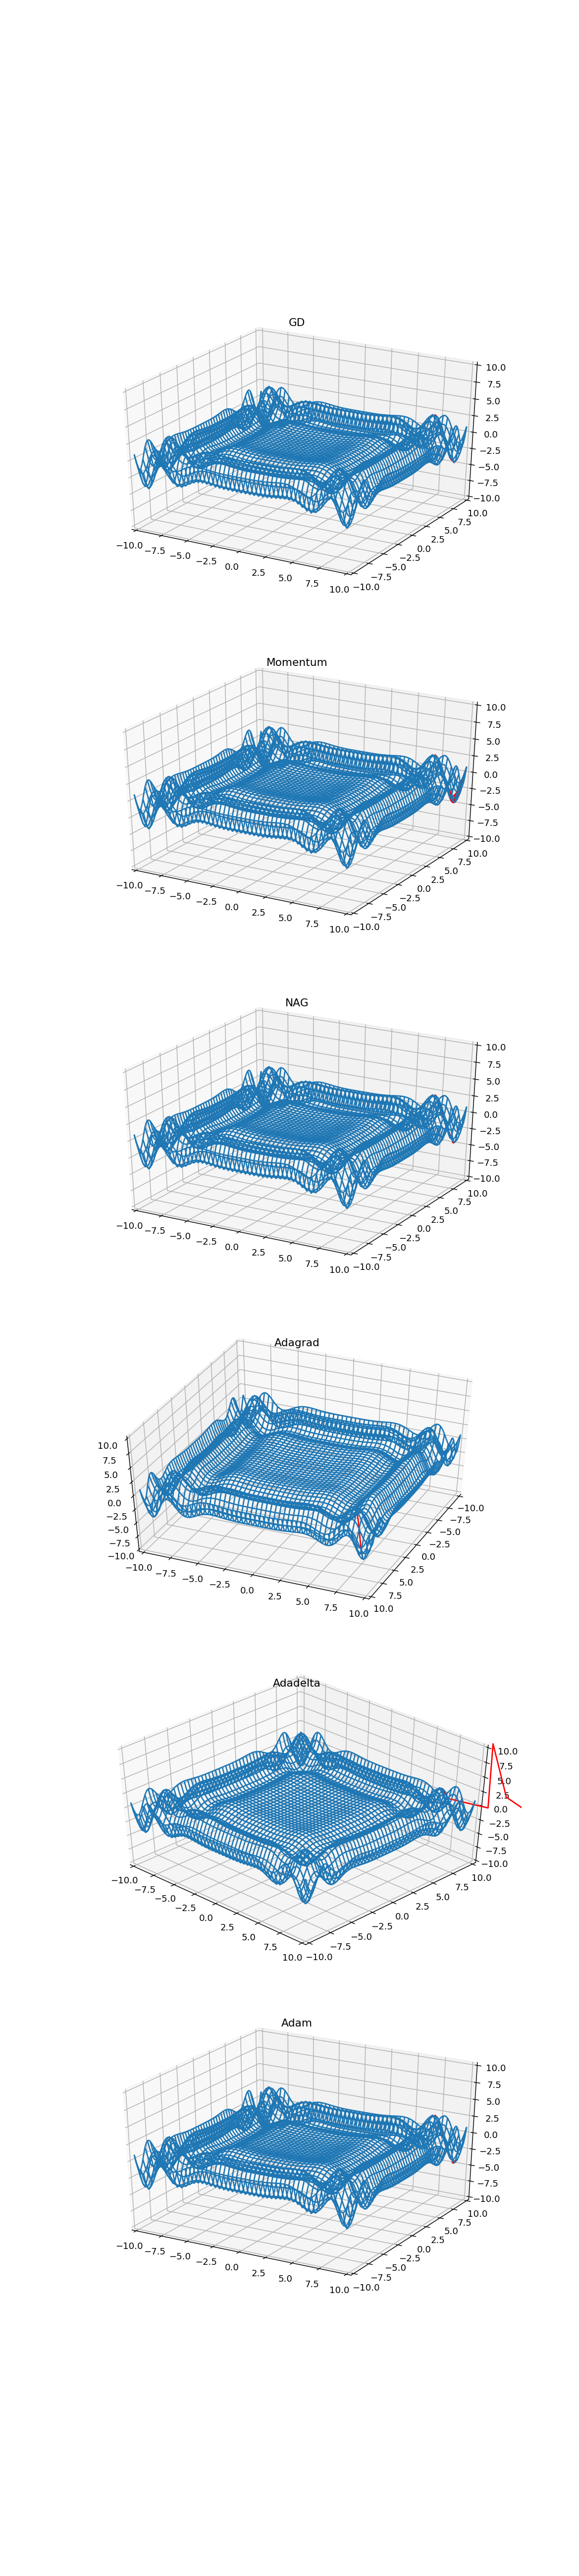

In [48]:
comparing(J3, optims)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [30]:
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.nn as nn
from torch.utils.data import DataLoader

In [31]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [33]:
def train(network, epochs, learning_rate, loss, optimizer):
    optimizer = optimizer(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, test_loss_epochs

In [34]:
class FullyConnectedClassifier_1(nn.Module):
    def __init__(self, image_size):
        super(FullyConnectedClassifier_1, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200), 
                                           nn.ReLU(),
                                           nn.Linear(200, 100),
                                           nn.Tanh(),
                                           nn.Linear(100, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [35]:
loss = nn.NLLLoss()
optims = [torch.optim.Adam, torch.optim.Adagrad, torch.optim.Adadelta, torch.optim.SGD]

In [36]:
all_trains = []
all_tests = []

for i in range(len(optims)):
    network_1 = FullyConnectedClassifier_1(image_size=28)
    train_loss_epochs, test_loss_epochs = train(network_1, 5, 1e-4, loss, optims[i])
    all_trains.append(train_loss_epochs)
    all_tests.append(test_loss_epochs)

<IPython.core.display.Javascript object>


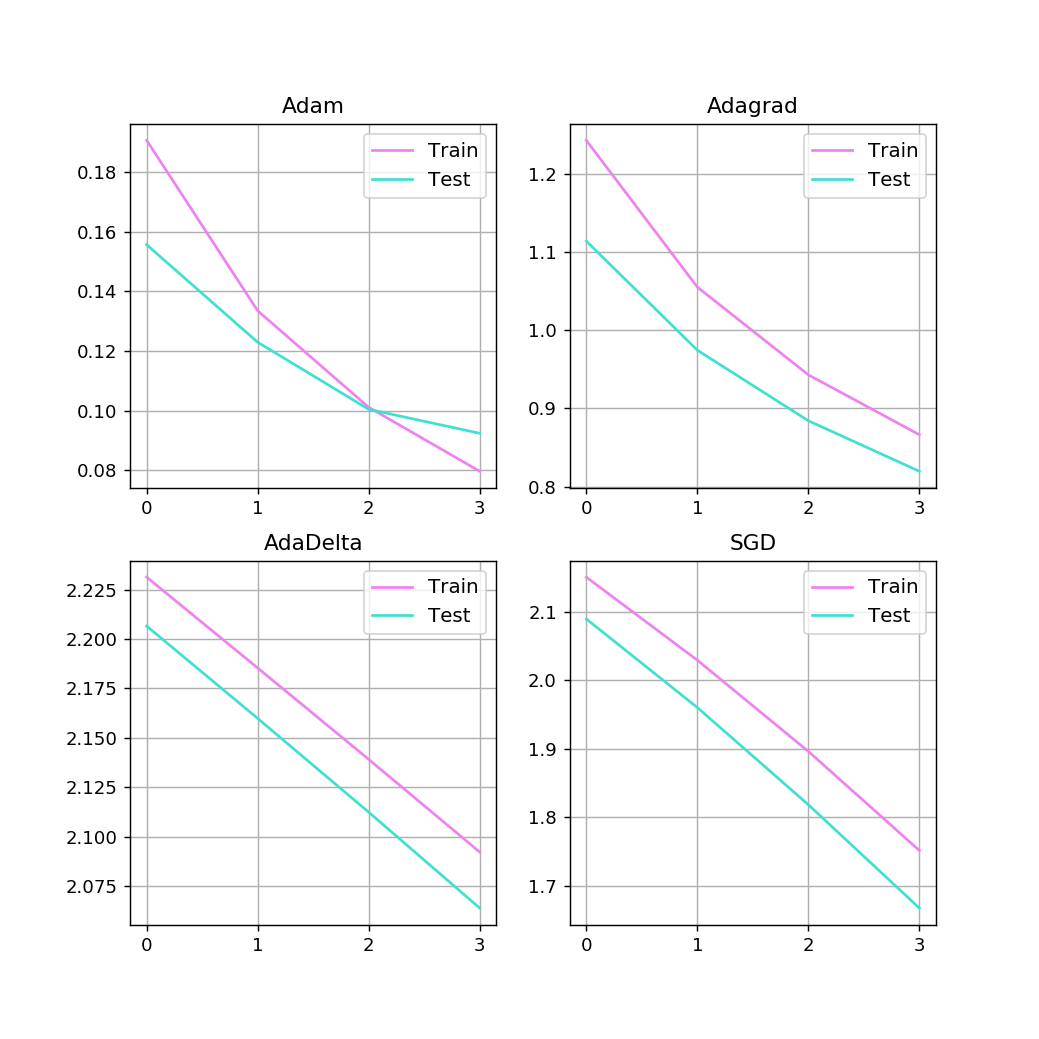

In [37]:
fig = plt.figure(figsize=(8, 8))
titles = ['Adam', 'Adagrad', 'AdaDelta', 'SGD']
ax = []

for i in range(len(optims)):
    ax.append(fig.add_subplot(221 + i))
    ax[i].plot(all_trains[i][1:], label='Train', color='violet')
    ax[i].plot(all_tests[i][1:], label='Test', color='turquoise')
    ax[i].legend(loc=1, fontsize=11)
    ax[i].grid('on')
    ax[i].set_title(titles[i])

plt.show()

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [7]:
def train(network, epochs, learning_rate, loss, optimizer):
    optimizer = optimizer(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, test_loss_epochs

In [8]:
in_channels_1 = 1
out_channels_1 = 8
kernel_size_1 = (3, 3)

in_channels_2 = 8
out_channels_2 = 16
kernel_size_2 = (3, 3)

class ConvClassifier_1(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_1, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels_1, out_channels_1, kernel_size_1, padding=1), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(in_channels_2, out_channels_2, kernel_size_2, padding=1),
                                         nn.ReLU())

        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [38]:
ima = 28
ima // 2 * ima // 2

196

In [9]:
loss = nn.NLLLoss()
optims = [torch.optim.Adam, torch.optim.Adagrad, torch.optim.Adadelta, torch.optim.SGD]

In [12]:
all_trains = []
all_tests = []

for i in range(len(optims)):
    network_1 = ConvClassifier_1(image_size=28)
    train_loss_epochs, test_loss_epochs = train(network_1, 8, 4e-4, loss, optims[i])
    all_trains.append(train_loss_epochs)
    all_tests.append(test_loss_epochs)

<IPython.core.display.Javascript object>


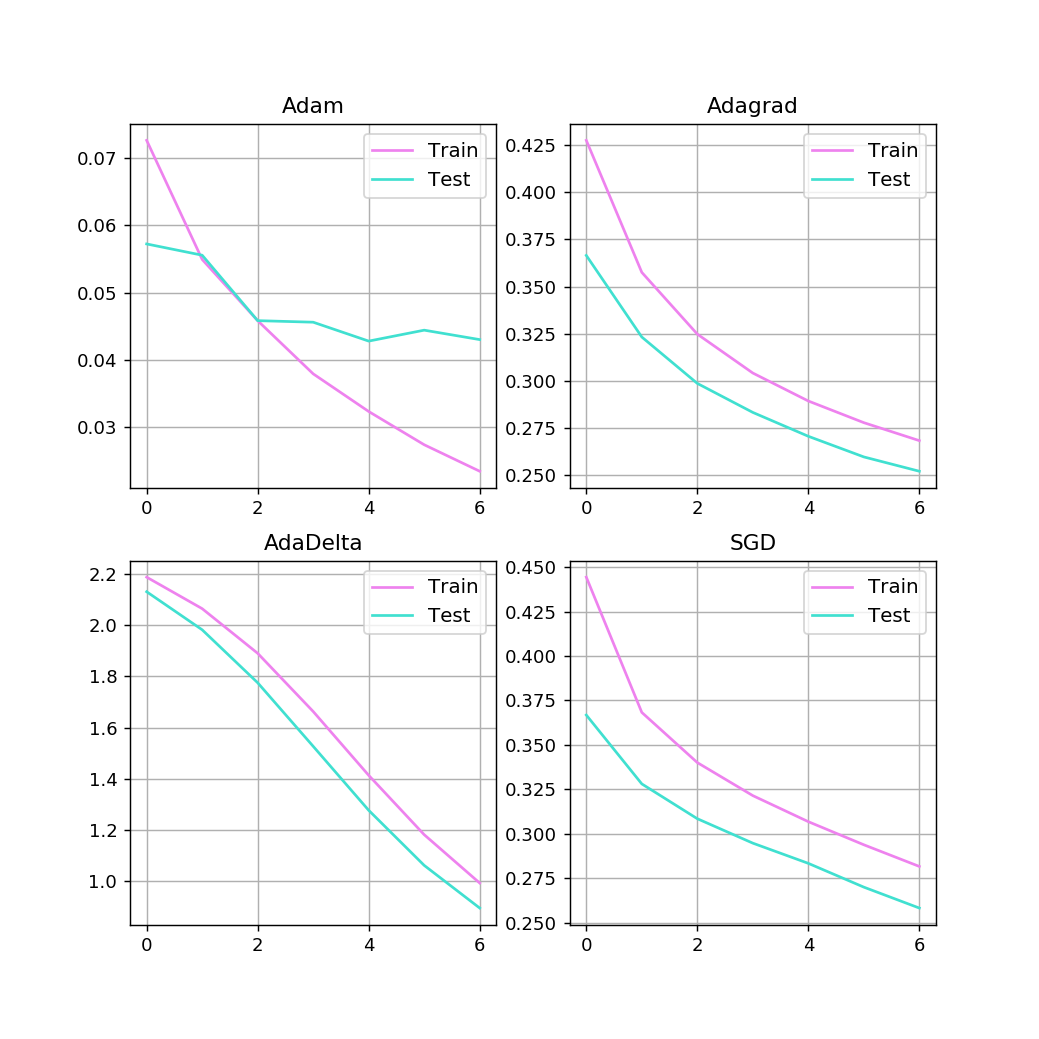

In [13]:
fig = plt.figure(figsize=(8, 8))
titles = ['Adam', 'Adagrad', 'AdaDelta', 'SGD']
ax = []

for i in range(len(optims)):
    ax.append(fig.add_subplot(221 + i))
    ax[i].plot(all_trains[i][1:], label='Train', color='violet')
    ax[i].plot(all_tests[i][1:], label='Test', color='turquoise')
    ax[i].legend(loc=1, fontsize=11)
    ax[i].grid('on')
    ax[i].set_title(titles[i])

plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: